# EDA

In [20]:
# 

import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import collections

import os
import warnings
warnings.filterwarnings('ignore')

root = '/kaggle/input/birdclef-2024'
# format root
 

## Directory

Folder format
- trainsets:
    - Audio (labeled): `root/train_audio/[label]/XC*.ogg`
    - Audio (unlabled): `root/unlabeled_soundspaces/*.ogg`
- Data on the relationships between different species (labels): `root/eBird_Taxonomy_v2021.csv`
- A wide range of metadata is provided for the training data: `root/train_metadata.csv`
- Testset: approx 1_100 ogg files (each 4 min long) at `root/test_soundspaces/soundscape_xxxxxx.ogg`



# Explanatory data analysis

In [24]:
def explore(df):
    explore = pd.DataFrame(df.dtypes, columns=['data type'])
    explore['missing'] = df.isnull().sum().values
    explore['unique_count'] = df.nunique().values 
    explore['duplicates'] = df.duplicated().sum()
    
    # numerical value information
    df_describe = pd.DataFrame(df.describe(include='all').transpose())
    explore['max'] = df_describe['max'].values
    explore['min'] = df_describe['min'].values
    explore['avg'] = df_describe['mean'].values
    explore['std'] = df_describe['std'].values
    explore['freq'] = df_describe['freq'].values
    return explore

## 1- `train_metadata.csv`

In [2]:
meta = pd.read_csv(root+'/train_metadata.csv')
meta.head(2)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg


In [29]:
print(f'train_metadata.csv, {meta.shape}')
explore(meta)

train_metadata.csv, (24459, 12)


,data type,missing,unique_count,duplicates,max,min,avg,std,freq
primary_label,object,0,182,0,NaN,NaN,NaN,NaN,500
secondary_labels,object,0,491,0,NaN,NaN,NaN,NaN,22567
type,object,0,918,0,NaN,NaN,NaN,NaN,6188
latitude,float64,378,9098,0,71.964,-43.524,32.53704,19.440382,NaN
longitude,float64,378,9182,0,177.4478,-171.7654,43.640699,50.191352,NaN
scientific_name,object,0,182,0,NaN,NaN,NaN,NaN,500
common_name,object,0,182,0,NaN,NaN,NaN,NaN,500
author,object,0,1942,0,NaN,NaN,NaN,NaN,915
license,object,0,4,0,NaN,NaN,NaN,NaN,22344
rating,float64,0,11,0,5.0,0.0,3.843493,1.10084,NaN


Total number of labels: 182


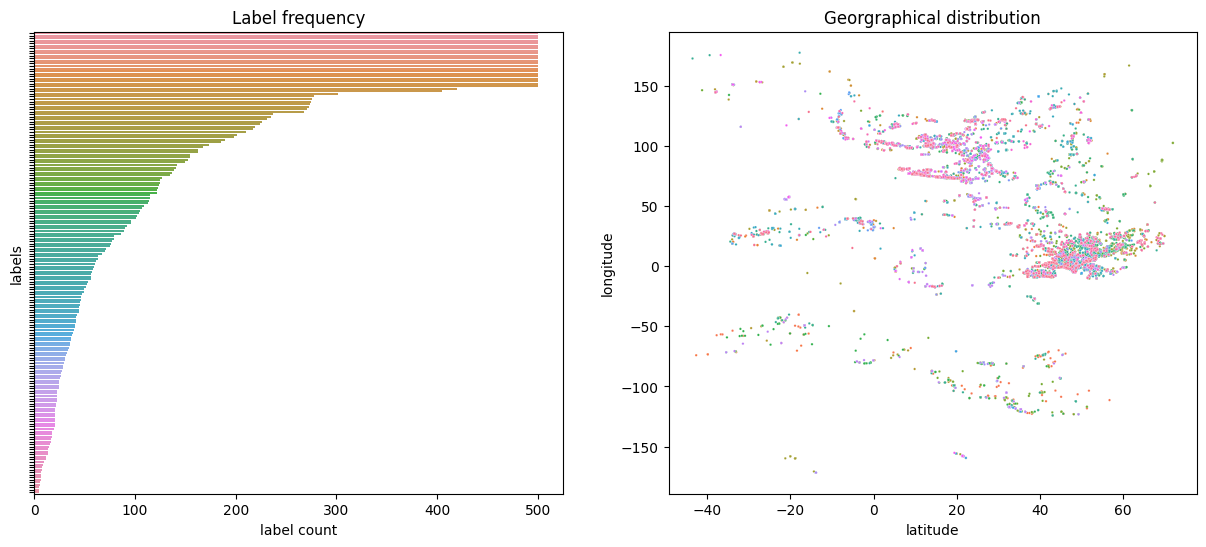

In [12]:
# labels counts
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
label_count = meta['primary_label'].nunique()
print(f'Total number of labels: {label_count}')
# label frequency
plt.title('Label frequency')
lbl_counts = meta['primary_label'].value_counts()
sns.barplot(x= lbl_counts.values, y = lbl_counts.index)
plt.yticks(visible=False)
plt.ylabel('labels')
plt.xlabel('label count')
# Clustering analysis of label geographical location
plt.subplot(1, 2, 2)
plt.title('Georgraphical distribution')
sns.scatterplot(data = meta, x= 'latitude' , y='longitude', s = 3, hue = 'primary_label')
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.legend([],[], frameon=False)


plt.show();

In [14]:
meta.rating.describe()

count    24459.000000
mean         3.843493
std          1.100840
min          0.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

## 2- labels (birds) taxonomy: `eBird_Taxonomy_v2021.csv`

In [20]:
taxonomy = pd.read_csv(root+'/eBird_Taxonomy_v2021.csv')
taxonomy.head(2)

,TAXON_ORDER,CATEGORY,SPECIES_CODE,PRIMARY_COM_NAME,SCI_NAME,ORDER1,FAMILY,SPECIES_GROUP,REPORT_AS
0,1,species,ostric2,Common Ostrich,Struthio camelus,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN
1,6,species,ostric3,Somali Ostrich,Struthio molybdophanes,Struthioniformes,Struthionidae (Ostriches),NaN,NaN


## Audio files

__Different representations of an audio file__
1. Waveform: represents the amplitude of the audio signal over time. [reference](https://en.wikipedia.org/wiki/Waveform#:~:text=In%20electronics%2C%20acoustics%2C%20and%20related,of%20any%20displacement%20in%20time.)
2. Spectrogram: shows the frequency content of the audio signal over time (2D image). [reference](https://en.wikipedia.org/wiki/Spectrogram)
3. Mel spectrogram: a spectrogram that uses the Mel scale on the y-axis to represent sound information in a way that's similar to how humans perceive it. [reference](https://ketanhdoshi.github.io/Audio-Mel/)
4. Chromagram: similar to the regular spectrogram, but the frequency scales are transformed to the Mel scale. [reference](https://doc.sccode.org/Classes/Chromagram.html#:~:text=A%20chromagram%2C%20measuring%20the%20energy,exact%20fft%20bin%20%2B%20interpolation%20data.)
5. MFCCs: represents the distribution of energy across the 12 pitch classes (notes) in the audio signal over time. [reference](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum)
6. Spectral contrast: a compact representation of the audio signal's spectral envelope, which captures important characteristics of the audio signal. [reference](https://librosa.org/doc/main/generated/librosa.feature.spectral_contrast.html)

 

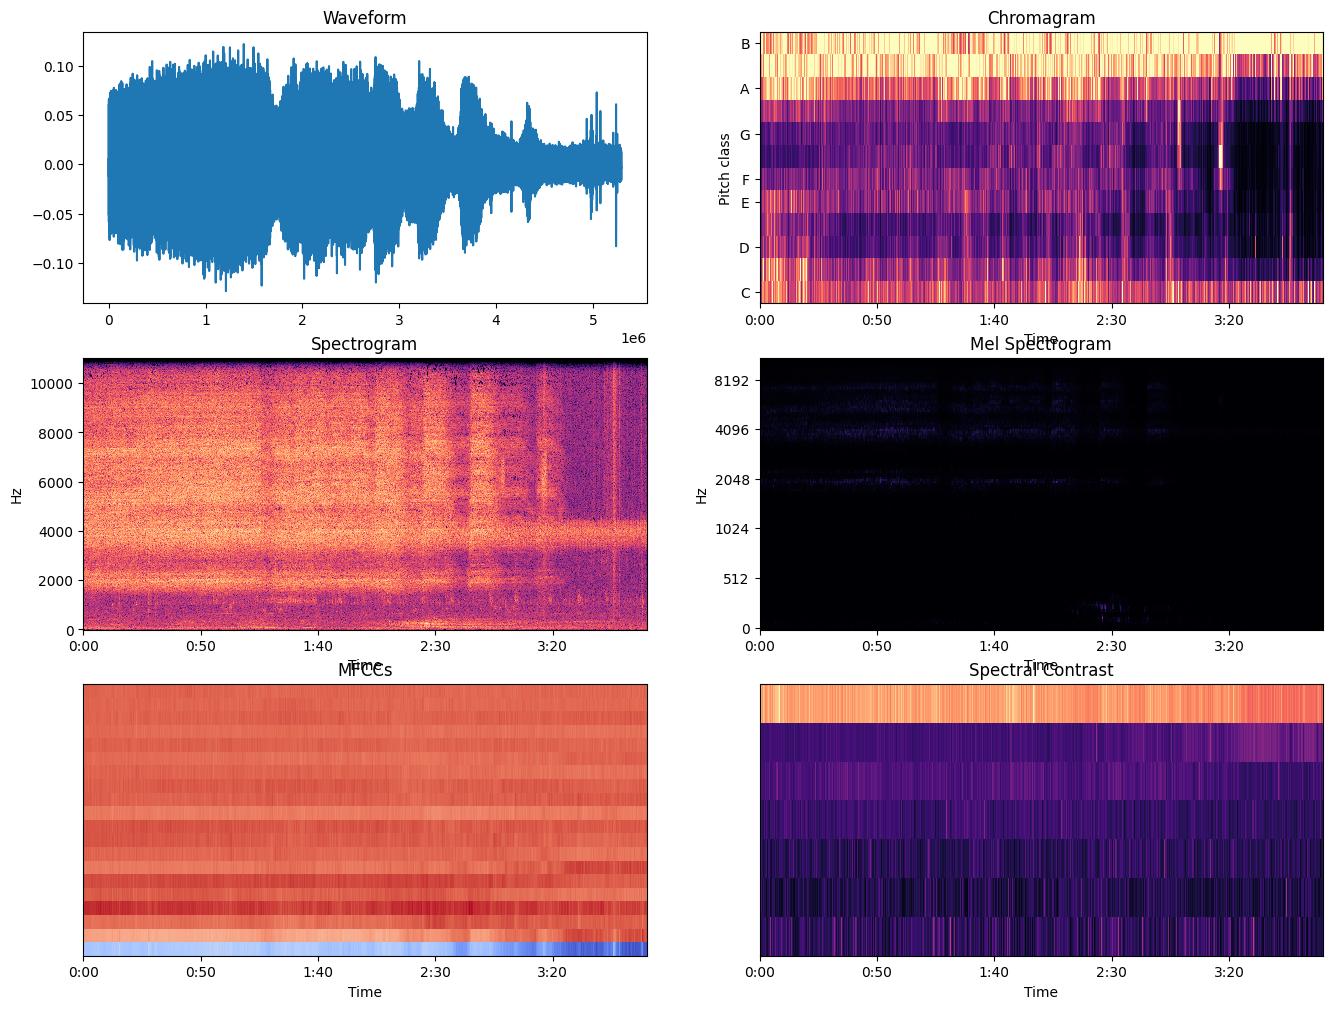

In [21]:
# visualization of a random audio file
import librosa
audio_sample, sample_rate = librosa.load(root+'/unlabeled_soundscapes/1000389428.ogg')

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))

#waveform
axs[0,0].set_title('Waveform')
axs[0,0].plot(audio_sample)

# Chromagram
chromagram_sample = librosa.feature.chroma_stft(y=audio_sample, sr=sample_rate)
librosa.display.specshow(chromagram_sample, x_axis='time', y_axis='chroma', sr=sample_rate, ax=axs[0, 1])
axs[0, 1].set_title('Chromagram')

# Spectrogram
spectogram_sample = librosa.amplitude_to_db(librosa.stft(audio_sample), ref=np.max)
librosa.display.specshow(spectogram_sample, sr=sample_rate, x_axis='time', y_axis='hz', ax=axs[1, 0])
axs[1,0].set_title('Spectrogram')

# Mel Spectrogram
mel_spectrogram_sample = librosa.feature.melspectrogram(y=audio_sample, sr=sample_rate)
librosa.display.specshow(mel_spectrogram_sample, x_axis='time', y_axis='mel', sr=sample_rate, ax=axs[1, 1])
axs[1, 1].set_title('Mel Spectrogram')

# MFCCs
mfccs_sample = librosa.feature.mfcc(y=audio_sample, sr=sample_rate)
librosa.display.specshow(mfccs_sample, x_axis='time', sr=sample_rate, ax=axs[2, 0])
axs[2, 0].set_title('MFCCs')

# Spectral contrast
spectral_contrast_sample = librosa.feature.spectral_contrast(y=audio_sample, sr=sample_rate)
librosa.display.specshow(spectral_contrast_sample, x_axis='time', sr=sample_rate, ax=axs[2, 1])
axs[2, 1].set_title('Spectral Contrast')

plt.show();